In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-nepali/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-nepali/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headings,paras,label
0,‘लभ स्टेसन’ भियतनाम र इन्डोनेसियामा,नेपाली कथानक फिल्म ‘लभ स्टेसन’ को टिम यति बेला...,entertainment
1,चाडबाडलगत्तै तरकारी सस्तियो,दसैंको मुखमा अस्वाभाविक बढेको तरकारी तथा फलफूल...,business
2,किङ्गफिसर बियर नेपाली बजारमा,एशियाकै ठूलो बियर कम्पनी मध्येको युनाइटेड ब्रु...,business
3,अर्बपतिका आँखा अन्तरिक्षतिर,संसारका धनाढ्यहरू अन्तरिक्ष यात्रालाई सस्तो र ...,business
4,‘आई एम सरी’ भन्दै सौगात,निकेश खड्का निर्देशित फिल्म ‘फाटेको जुत्ता’ को...,entertainment


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headings,paras,label
0,१ अर्ब ३९ करोड बजेट फ्रिज,आर्थिक वर्ष २०७४/७५ मा जिल्लामा आएको १ अर्ब ३९...,business
1,पुनर्निर्माणमा भारतको डेढ अर्ब,गोरखा र नुवाकोटमा भूकम्पबाट क्षतिग्रस्त पचास ह...,business
2,आपूर्ति विभागलाई शक्तिशाली बनाइँदै,सरकारले उपभोक्ता ठगी गर्ने व्यवसायीलाई वाणिज्य...,business
3,स्वरसम्राट्को सम्झनामा संग्रहालय,स्वरसम्राट् नारायणगोपालको सम्झनामा संग्रहालय ब...,entertainment
4,लुम्बिनी सेमिफाइनलमा,लुम्बिनी खुकुरी क्रिकेट क्लब रूपन्देही सुपर लि...,sports


In [9]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
entertainment 1817
business 2118
sports 2040


In [11]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
business 510
entertainment 451
sports 534


In [12]:
train_df['headings'][0]

'‘लभ स्टेसन’ भियतनाम र इन्डोनेसियामा'

In [13]:
train_df.shape, valid_df.shape

((5975, 3), (1495, 3))

In [14]:
train_df[train_df['headings'].isnull()].shape, valid_df[valid_df['paras'].isnull()].shape

((0, 3), (0, 3))

In [16]:
label_cols = list(range(2,train_df.shape[1]))

In [17]:
print(label_cols)

[2]


In [19]:
id_to_col = list(train_df.columns)

In [20]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [21]:
class NepaliTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/nepali_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [22]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/nepali_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(15000)]

In [23]:
itos[:10]

['<unk>', '<s>', '</s>', '▁', 'को', '।', ',', 'मा', '▁।', '▁र']

In [24]:
# 15,000 is the vocab size that we chose in sentencepiece
nepali_vocab = Vocab(itos)

In [25]:
tokenizer = Tokenizer(tok_func=NepaliTokenizer, lang='ne')

In [26]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [27]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0,1], label_cols=label_cols, tokenizer=tokenizer, vocab=nepali_vocab, bs=16)

In [28]:
data_lm.save()

In [29]:
data_lm.show_batch()

idx,text
0,▁टिम ▁यी ▁देश ▁पुगेका ▁हुन् ▁। ▁ x x b os ▁चाड बा ड लग त्त ै ▁तरकारी ▁स स्त ियो ▁दसैं को ▁मुखमा ▁अ स्वा भाव िक ▁बढेको ▁तरकारी ▁तथा ▁फलफूल को ▁भा उ ▁घट ्न ▁थालेको ▁छ ▁। ▁उत्पादन ▁वृद्धि सँगै ▁सहज ▁आपूर्ति का ▁कारण ▁मूल्य ▁घटे को ▁हो ▁। ▁ x x b os ▁कि ङ्ग फिस र ▁बियर ▁नेपाली ▁बजारमा ▁एशिय ा कै ▁ठूलो ▁बियर ▁कम्पनी
1,"▁श्रेष्ठ ले ▁फिल्म ▁‘ कथा ▁काठ मा ण्ड ु ’ ▁मार्फत ▁निर्देशन मा ▁डेब्यु ▁गर्न ▁लागे की ▁छन् ▁। ▁ x x b os ▁अभिनेत्री ▁ए न्स र्ज ▁भन्छ िन् , ▁‘ संस्कृति का ▁लागि ▁फिल्म ’ ▁पछिल्लो ▁समय ▁आदिवासी ▁जनजाति ▁फिल्म हरूलाई ▁लागेको ▁एउटै ▁आरोप ▁छ – ▁भाषा ▁मात्रै ▁सम्बन्धित ▁समुदाय को , ▁विषयवस्तु ▁र ▁प्रस्तुति ▁भने ▁नेपाली ▁या ▁हिन्दी बाटै ▁प्रभावित ▁। ▁तामाङ , ▁मगर , ▁गुरुङ ▁या"
2,स्क्रिप्ट ▁तयार ▁पारे ▁। ▁ज्याक ी ले ▁नै ▁फिल्म ▁निर्माण सँगै ▁अभिनय समेत ▁गरे ▁। ▁ x x b os ▁पि ं का थन ▁शनिबार ▁भारतका ▁आठ ▁सहरमा ▁गरी ▁ <unk> ▁हजार ▁महिला ▁सहभागी ▁हुने ▁पि ं का थन ▁दौड ▁ गत ▁सालदेखि ▁नेपालमा ▁पनि ▁सुरु ▁भएको ▁हो ▁। ▁यसका ▁संस्थापक ▁मिलि न्द ▁सोम न ▁कार्यक्रम का ▁लागि ▁पटक – पटक ▁नेपाल ▁आउने ▁गरेका ▁छन् ▁। ▁काठमाडौं को ▁दौड मा
3,"’ ▁ ले ▁पहिलो ▁पटक ▁अमेरिका ▁टु र ▁गर्न ▁लागेको ▁छ ▁। ▁असार ▁ <unk> ▁देखि ▁साउन भर ▁उता का ▁विभिन्न ▁सहरमा ▁प्रस्तुति ▁दिने ▁ब्यान्ड ले ▁जानकारी ▁दिएको ▁छ ▁। ▁ x x b os ▁यस्तो ▁भयो ▁ग्या ल् बो ▁ल्होसार ▁शुक्रबार देखि ▁शेर्पा , ▁ह यो ल्मो लगायत ▁हिमाली ▁समुदाय को ▁नयाँ ▁बर्ष ▁ग्या ल् बो ▁ल्होसार ▁सुरु ▁भयो ▁। ▁यस पटक ▁मल मा स ▁परेका ले ▁केही ▁तामाङ"
4,▁लागि ▁धेरै ▁समीकरण ▁बाँकी ▁छैन ▁। ▁जि म्बा वे मा ▁भइरहेको ▁प्रतियोगितामा ▁नेपालले ▁बाँकी ▁ <unk> ▁खेलमा ▁स्पष्ट ▁विजय ▁हात ▁पार्न ुपर्छ ▁। ▁सुपर ▁सि क्स मा ▁पुग्न ▁अफगानिस्तान ▁र ▁हङकङ को ▁चाहिँ ▁खेल ▁जित्न ै पर्छ ▁। ▁ x x b os ▁जे शि का को ▁सन स नी ▁इटहरी मा ▁जारी ▁सातौं ▁पुष्पलाल ▁स्मृति ▁राष्ट्रिय ▁ब्याडमिन्टन मा ▁शुक्रबार ▁झापा की ▁जे शि का ▁गुरुङ ले ▁राष्ट्रिय ▁च्याम्पियन ▁न


In [30]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150

In [31]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [35]:
# Loading the pretrained language model on nepali wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-nepali/language-model/NepaliDataset/models/third_ne_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5975 items)
x: LMTextList
▁ x x b os ▁‘ ल भ ▁स्टेसन ’ ▁भियतनाम ▁र ▁इन्डोनेसिया मा ▁नेपाली ▁कथानक ▁फिल्म ▁‘ ल भ ▁स्टेसन ’ ▁को ▁टिम ▁यति ▁बेला ▁भियतनाम ▁र ▁इन्डोनेसिया मा ▁छ ▁। ▁फिल्म को ▁गीत ▁छाया ंक न का ▁लागि ▁अभिनेता ▁प्रदीप ▁खड्का , ▁अभिनेत्री ▁जस िता ▁गुरुङ , ▁निर्माता ▁गोविन्द ▁शाही , ▁को रियो ग्राफ र ▁शिशिर ▁खा ती , ▁क्यामेरा ▁पर् सन ▁आ लोक ▁शुक्ल ा सहित को ▁टिम ▁यी ▁देश ▁पुगेका ▁हुन् ▁।,▁ x x b os ▁चाड बा ड लग त्त ै ▁तरकारी ▁स स्त ियो ▁दसैं को ▁मुखमा ▁अ स्वा भाव िक ▁बढेको ▁तरकारी ▁तथा ▁फलफूल को ▁भा उ ▁घट ्न ▁थालेको ▁छ ▁। ▁उत्पादन ▁वृद्धि सँगै ▁सहज ▁आपूर्ति का ▁कारण ▁मूल्य ▁घटे को ▁हो ▁।,▁ x x b os ▁कि ङ्ग फिस र ▁बियर ▁नेपाली ▁बजारमा ▁एशिय ा कै ▁ठूलो ▁बियर ▁कम्पनी ▁मध्येको ▁युनाइटेड ▁ब्रु अर ीज ▁लिमिटेड ले ▁यति ▁ब्रु अ री सँग को ▁सहकार्य मा ▁कि ङ्ग फिस र ▁बियर ▁बजारमा ▁ल्याएको ▁छ ▁।,▁ x x b os ▁अर्ब पति का ▁आँखा ▁अन्तरिक्ष तिर ▁संसार का ▁धन ा ढ ्य हरू ▁अन्तरिक्ष ▁यात्रा लाई ▁सस्तो ▁र ▁व्यावसायिक ▁रूपमा ▁सा कार ▁बनाउने ▁अभिय

In [36]:
# Fine tuning the prtrained LM on current dataset

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


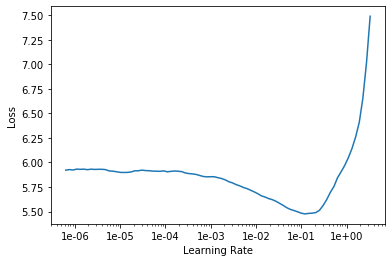

In [38]:
learn.recorder.plot()

In [39]:
learn.freeze()

In [40]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.567451,4.399014,0.324680,00:25


In [41]:
learn.unfreeze()

In [42]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.132091,4.220311,0.343497,00:28
1,3.903624,4.040626,0.365509,00:28
2,3.585473,3.966131,0.377690,00:28
3,3.339924,3.952757,0.380743,00:28
4,3.225586,3.963553,0.380600,00:29


In [43]:
learn.predict('हिमालय ट्राभल',n_words=10)

'हिमालय ट्राभल का रि मा ▁एन भी एम ▁बैंक ▁आज देखि ▁मुलुक'

In [44]:
learn.save_encoder('fine_tuned_enc')

In [45]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=nepali_vocab, text_cols=[0,1], label_cols=label_cols, bs=16)

In [46]:
data_clas.show_batch()

text,target
▁ x x b os ▁गुरुकुल ▁न खु ले को ▁भए ▁रक्सी ▁बेच िरहेको ▁हुन्थे ं ▁: ▁' भ ष् मे ▁ डन ' ▁उम् दा ▁अनुहार ▁पनि ▁हैन ▁। ▁बलि ष्ठ ▁ज्यान ▁पनि ▁छैन ▁। ▁तर ▁वि पि न ▁कार्की ▁‘ हि रो ’ ▁बनेर ▁देखिए ▁‘ जात्रा ’ ▁मा ▁। ▁हुन ▁त ▁त्यसअघि ▁नै ▁उनी ▁‘ प शु पति ▁प्रसाद ’ ▁बाट ▁भ ष् मे ▁ डन का,entertainment
"▁ x x b os ▁डिस् को ▁किङ ▁ब प्प ी ▁ न् ▁ <unk> ▁र ▁ <unk> ▁को ▁दशक ▁ब प्प ी ▁ला हि री को ▁थियो । ▁त्यो ▁बेला ▁उनले ▁संगीत ▁भर े का ▁जुन ▁कुनै ▁गीत ▁सुपर ▁हिट ▁हुन्थे । ▁‘ या द ▁आ ▁र हा ▁है ▁ते रा ▁प्यार ... ’ , ▁‘ आई ▁एम ▁अ ▁डिस् को ▁डान्स र ... ’ ▁‘ ज वानी ▁जाने",entertainment
▁ x x b os ▁‘ फे रि ▁फेरि ’ ▁मा ▁ऋ चा – अ र्पण ▁अभिनेता ▁/ ▁निर्देशक ▁अर्पण ▁थापा ▁र ▁अभिनेत्री ▁ऋ चा ▁शर्मा बीच ▁पछिल्लो ▁समय ▁फिल्म ी ▁सहकार्य ▁बा क्ल िएको ▁छ ▁। ▁पछिल्लो ▁पटक ▁अर्पण ले ▁आफूले ▁निर्देशन ▁गरेको ▁‘ आ धा ▁लभ ’ ▁मा ▁ऋ चा लाई ▁नै ▁मुख्य ▁भूमिकामा ▁प्रस्तुत ▁गरेका ▁थिए ▁भने ▁आफूले ▁पनि ▁स्क्रिन ▁सेयर ▁गरेका ▁थिए ▁। ▁पछि ▁यो ▁जोडी,entertainment
▁ x x b os ▁नेपालमा ▁पनि ▁लोकप्रिय ▁बन्दै ▁दक्षिण ▁भारतीय ▁फिल्म ▁पछिल्लो ▁समय ▁दक्षिण ▁भारतीय ▁फिल्म को ▁प्रभाव ▁विश्वव्यापी ▁बन्दै ▁गइरहेको ▁छ ▁। ▁नेपाल ▁पनि ▁अ छु तो ▁छैन ▁। ▁मंगलबार को ▁यु ट यु ब ▁ट्रे न्ड िङ ले ▁पनि ▁यसलाई ▁पुष्टि ▁गरेको ▁छ ▁। ▁मा ही ▁वी ▁राघव ▁निर्देशित ▁‘ क ञ्च ना ▁ <unk> ’ ▁र ▁भा ष् कर ▁निर्देशित ▁‘ राम की ▁जंग ’ ▁मंगलबार,entertainment
▁ x x b os ▁ने प्स े ▁ <unk> ▁सय ▁तल ▁काठमाडौं – ▁सोमबार ▁करिब ▁ <unk> ▁अंक ले ▁घटे को ▁बजार ▁मंगलबार ▁ <unk> ▁अंक भन्दा ▁धेरै ले ▁ओराल ो ▁लाग्यो ▁। ▁मंगलबार को ▁गिरावट ले ▁सेयर ▁कारोबार ▁मा पक ▁ने प्स े ▁परि सू चक ▁ <unk> ▁हजार ▁ <unk> ▁सय भन्दा ▁तल ▁ ( <unk> ▁हजार ▁ <unk> ▁सय ▁ <unk> . <unk> ) ▁झरे को,business


In [47]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [48]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [49]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5975 items)
x: TextList
▁ x x b os ▁‘ ल भ ▁स्टेसन ’ ▁भियतनाम ▁र ▁इन्डोनेसिया मा ▁नेपाली ▁कथानक ▁फिल्म ▁‘ ल भ ▁स्टेसन ’ ▁को ▁टिम ▁यति ▁बेला ▁भियतनाम ▁र ▁इन्डोनेसिया मा ▁छ ▁। ▁फिल्म को ▁गीत ▁छाया ंक न का ▁लागि ▁अभिनेता ▁प्रदीप ▁खड्का , ▁अभिनेत्री ▁जस िता ▁गुरुङ , ▁निर्माता ▁गोविन्द ▁शाही , ▁को रियो ग्राफ र ▁शिशिर ▁खा ती , ▁क्यामेरा ▁पर् सन ▁आ लोक ▁शुक्ल ा सहित को ▁टिम ▁यी ▁देश ▁पुगेका ▁हुन् ▁।,▁ x x b os ▁चाड बा ड लग त्त ै ▁तरकारी ▁स स्त ियो ▁दसैं को ▁मुखमा ▁अ स्वा भाव िक ▁बढेको ▁तरकारी ▁तथा ▁फलफूल को ▁भा उ ▁घट ्न ▁थालेको ▁छ ▁। ▁उत्पादन ▁वृद्धि सँगै ▁सहज ▁आपूर्ति का ▁कारण ▁मूल्य ▁घटे को ▁हो ▁।,▁ x x b os ▁कि ङ्ग फिस र ▁बियर ▁नेपाली ▁बजारमा ▁एशिय ा कै ▁ठूलो ▁बियर ▁कम्पनी ▁मध्येको ▁युनाइटेड ▁ब्रु अर ीज ▁लिमिटेड ले ▁यति ▁ब्रु अ री सँग को ▁सहकार्य मा ▁कि ङ्ग फिस र ▁बियर ▁बजारमा ▁ल्याएको ▁छ ▁।,▁ x x b os ▁अर्ब पति का ▁आँखा ▁अन्तरिक्ष तिर ▁संसार का ▁धन ा ढ ्य हरू ▁अन्तरिक्ष ▁यात्रा लाई ▁सस्तो ▁र ▁व्यावसायिक ▁रूपमा ▁सा कार ▁बनाउने ▁अभियानमा 

In [50]:
learn.freeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


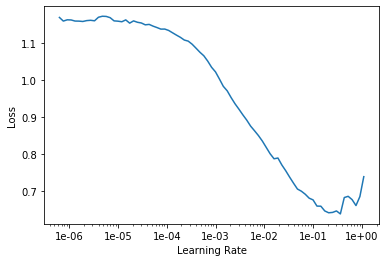

In [52]:
learn.recorder.plot()

In [53]:
learn.loss_func.func

CrossEntropyLoss()

In [54]:
kappa = KappaScore()

In [55]:
learn.metrics = [kappa, accuracy]

In [56]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.171407,0.101433,0.954772,0.969900,00:18


In [57]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.130235,0.091205,0.955756,0.970569,00:19


In [58]:
learn.save('second-full')

In [59]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.104383,0.068865,0.966808,0.977926,00:30
1,0.091685,0.053718,0.972846,0.981940,00:28
2,0.033540,0.076467,0.968830,0.979264,00:30
3,0.020372,0.062270,0.977876,0.985284,00:30
4,0.006947,0.060823,0.977873,0.985284,00:31


Better model found at epoch 0 with accuracy value: 0.9779264330863953.
Better model found at epoch 1 with accuracy value: 0.9819397926330566.
Better model found at epoch 3 with accuracy value: 0.9852842688560486.


In [60]:
learn.predict('फेसबुकले बेहोर्‍यो हालसम्मकै सबभन्दा खराब समस्या')

(Category entertainment, tensor(1), tensor([0.0256, 0.9733, 0.0011]))

In [61]:
learn.predict("साफ महिला च्याम्पियनसिप : बंगालदेश र भुटान भिड्दै")

(Category sports, tensor(2), tensor([1.8947e-04, 1.2981e-02, 9.8683e-01]))

In [62]:
learn.predict("अष्ट्रेलियालाई एकदिवसीय सिरिज, घरेलु मैदानमा गुमायो भारतले मौका")

(Category sports, tensor(2), tensor([4.3709e-05, 2.5377e-05, 9.9993e-01]))

In [63]:
learn.predict("बंगलादेशविरुद्ध टेस्ट सिरज न्यूजिल्यान्डले जित्यो")

(Category sports, tensor(2), tensor([8.5025e-05, 1.8045e-03, 9.9811e-01]))

In [64]:
learn.predict("लगानी सम्मेलनमा प्रस्तुत गर्न ४३ परियोजना निश्चित")

(Category business, tensor(0), tensor([0.5763, 0.4222, 0.0015]))